# My Hough Line  Detection

- author : Sylvie Dagoret-Campagne
- afflilation : LAL/IJCLab, CNRS
- creation date : January 10th 2020
- update : 
  - January 11th 2020 : My Hough line detection
  - January 13th 2020 : Draw my Aigrettes lines
  - January 14th 2020 : Fit Aigrettes lines with ODR

In [109]:
import os
import re
import numpy as np

In [110]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [111]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

In [112]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser

In [113]:
from math import ceil,floor
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle

In [114]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,8)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

In [115]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [116]:
from FeaturesExtractor.config import *
from FeaturesExtractor.features.images import *
from FeaturesExtractor.features.features import *
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

In [117]:
from skimage import feature

In [118]:
from skimage.feature import peak_local_max
from skimage.filters import sobel
from skimage import morphology

In [119]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line

In [120]:
from skimage.filters import gaussian

In [121]:
from scipy import odr

In [122]:
from scipy.signal import find_peaks

# Input file

In [123]:
datafiles=["CTIO_reduc_20170531_169.fits",
           "T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red.fit",
           "T1M_20190215_194504_399_PNK448_Filtre_None_bin1x1.1_red.fit",
           "T1M_20190215_225847_115_HD116405_Filtre_None_bin1x1.6_red.fit",
           "T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit", 
           "T1M_20190215_225922_399_HD116405_Filtre_None_bin1x1.7_red.fit",
           "T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red.fit",
           "T1M_20190215_225957_677_HD116405_Filtre_None_bin1x1.8_red.fit",
           "T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red.fit",   
           "T1M_20190215_230032_956_HD116405_Filtre_None_bin1x1.9_red.fit",
           "T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red.fit",   
           "T1M_20190215_230108_233_HD116405_Filtre_None_bin1x1.10_red.fit"]

In [124]:
inputdir="../../tests/data/"

In [125]:
fileindex=8

In [126]:
inputfile="../../tests/data/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit"

In [127]:
inputfile=os.path.join(inputdir,datafiles[fileindex])

In [128]:
configfile='../../config/picdumidi.ini'

# Start

In [129]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [130]:
#--------- Start Logger
my_logger = set_logger("TestCannyEdgesDetection")
my_logger.info('\n\tStart TestCannyEdgesDetection')

2020-01-14 21:23:54  TestCannyEdgesDetection <module>             INFO   
	Start TestCannyEdgesDetection


In [131]:
#--------- Load config file ---------------
load_config(configfile)

In [132]:
#-------- Load reduced image
image = Image(inputfile)

2020-01-14 21:23:54  Image      load_image           INFO   
	Image in file  ../../tests/data/T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red.fit loaded


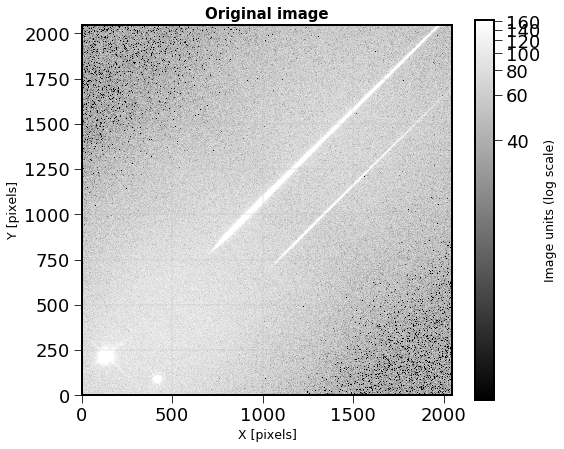

In [133]:
#if parameters.DEBUG and parameters.FLAG_PLOT_IMG :
if parameters.DEBUG  :
    image.plot_image(scale='log',title="Original image",cmap=plt.cm.gray)

In [134]:
#-----------------------------------------------------------------------------------------------------------
# Process the whole image by calculating Hessian, and its Eigen values images (lambda_plus and lambda_minus) and theta as well
#-----------------------------------------------------------------------------------------------------------
image.process_image()

2020-01-14 21:23:55  Image      process_image        INFO   
	Size of original image (Nx,Ny) = (2048,2048)
2020-01-14 21:23:55  Image      process_image        INFO   
	Size of processed image (Nx,Ny) = (2046,2046)
2020-01-14 21:23:55  Image      process_image        INFO   
	Padding of processed image (Xpad,Ypad)  = (1,1)
2020-01-14 21:23:55  Image      process_image        INFO   
	Image processed


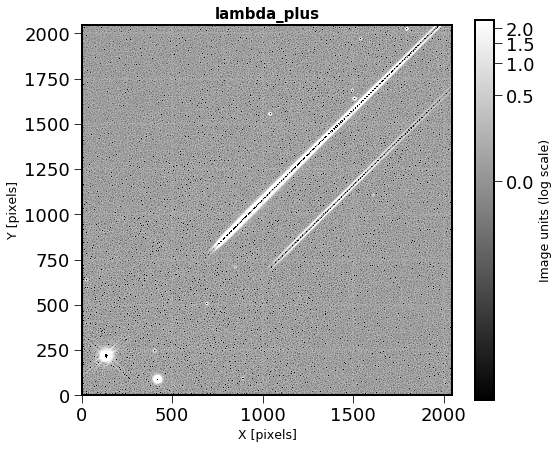

In [135]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_PLUS:
if parameters.DEBUG :
    image.plot_image(img_type="lambda_p",scale='log',title="lambda_plus",cmap=plt.cm.gray)


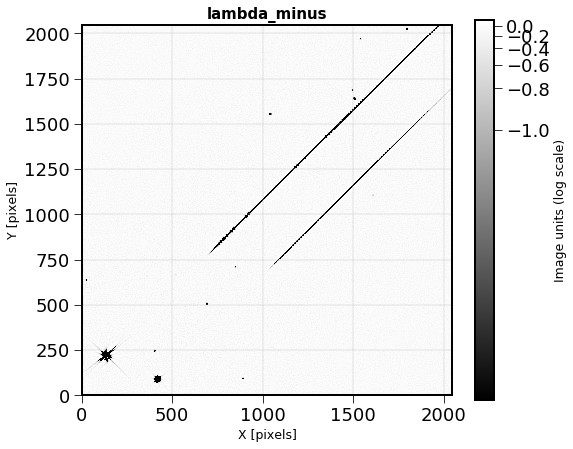

In [136]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_MINUS:
if parameters.DEBUG:
    image.plot_image(img_type="lambda_m", scale='log', title="lambda_minus",cmap=plt.cm.gray)

In [137]:
# ----------------------------------------------------------------------------------------------------------
# Clip Minimal and maximal values inside the images
#------------------------------------------------------------------------------------------------------------
image.clip_images()

2020-01-14 21:23:57  Image      clip_images          INFO   
	Images clipped


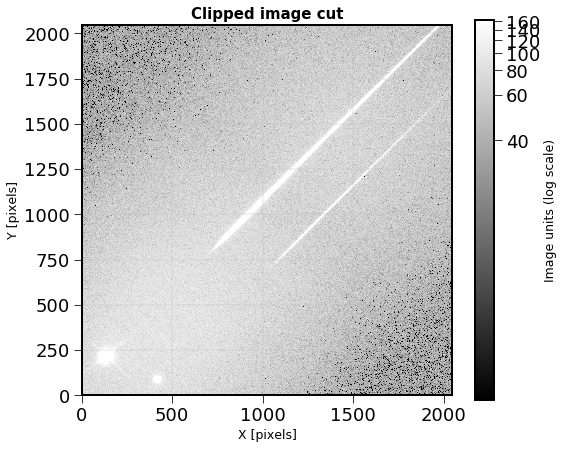

In [138]:
#if parameters.DEBUG and parameters.FLAG_PLOT_IMG_CLIP:
if parameters.DEBUG :
    image.plot_image(img_type="img_cut",scale='log',title="Clipped image cut",cmap=plt.cm.gray)

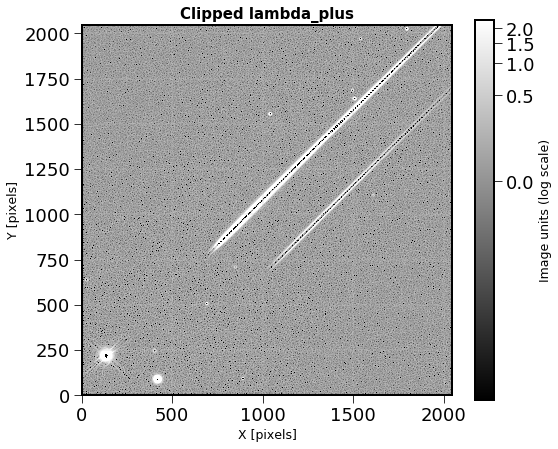

In [139]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_PLUS_CLIP:
if parameters.DEBUG :
    image.plot_image(img_type="lambda_p_cut",scale='log',title="Clipped lambda_plus",cmap=plt.cm.gray)  

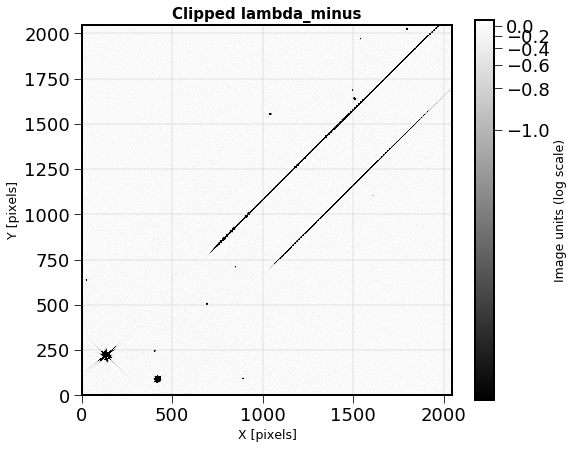

In [140]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_MINUS_CLIP:
if parameters.DEBUG :
    image.plot_image(img_type="lambda_m_cut", scale='log', title="Clipped lambda_minus",cmap=plt.cm.gray)

In [141]:
#-------------------------------------------------------------------------------------------------------------
# Calculate edges inside the images on lambda_plus and lambda_minus
#-------------------------------------------------------------------------------------------------------------
image.compute_edges()   

2020-01-14 21:24:02  Image      compute_edges        INFO   
	Images edges computed


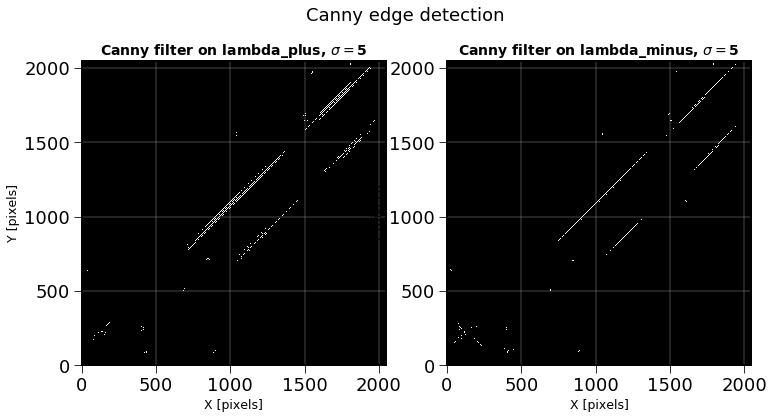

In [142]:
if parameters.DEBUG and ( parameters.FLAG_PLOT_LAMBDA_MINUS_EDGES or parameters.FLAG_PLOT_LAMBDA_PLUS_EDGES):
    image.plot_edges()

# Work with lambda\_minus

In [143]:
#lambda_minus=np.copy(image.img_cube[parameters.IndexImg.lambda_minus])
lambda_minus=np.copy(image.img_cube[parameters.IndexImg.lambda_minus_clip])

main_title="lambda_minus clipped"

Text(0.5, 0.8, 'lambda_minus clipped')

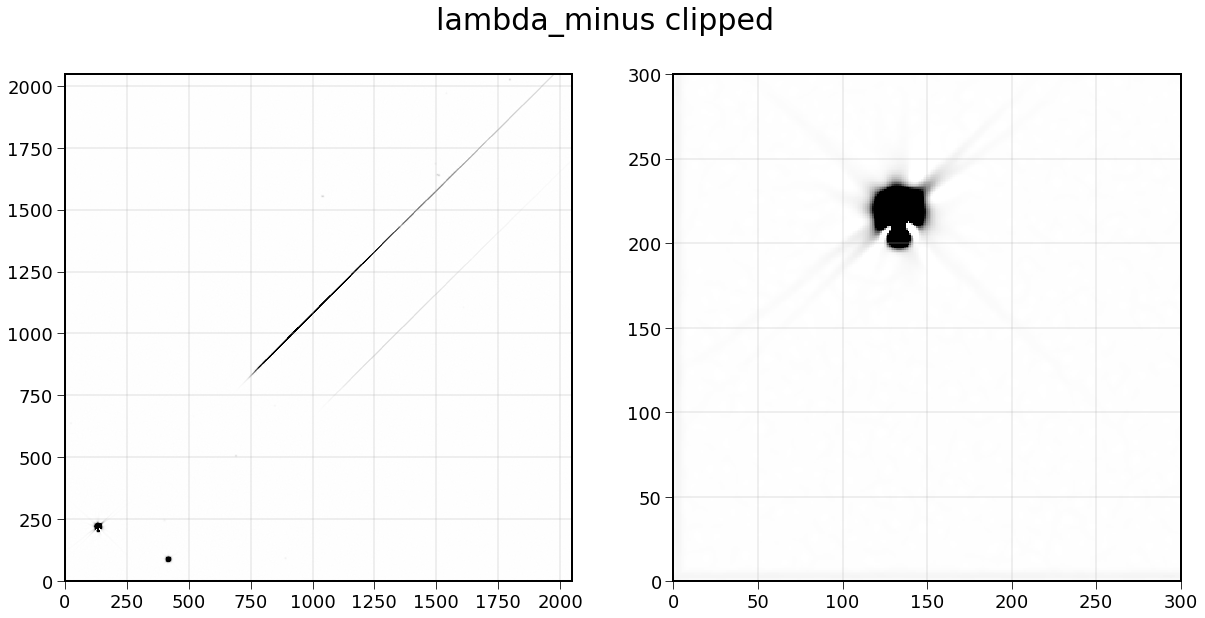

In [144]:
fig=plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
plt.grid()
plt.subplot(1,2,2)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
plt.xlim(0,300)
plt.ylim(0,300)
plt.grid()
plt.suptitle(main_title,fontsize=30,y=.8)

Text(0.5, 0.8, 'lambda_minus clipped reversed ')

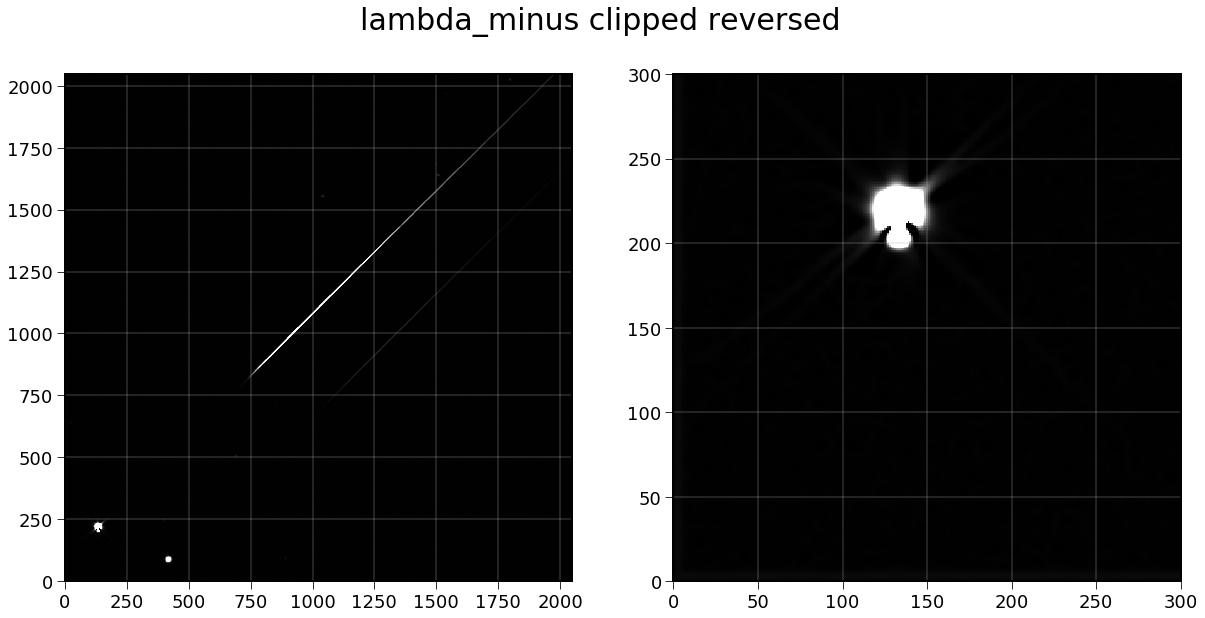

In [145]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
img=plt.imshow(-lambda_minus,origin="lower",cmap="gray")
plt.grid()
plt.subplot(1,2,2)
img=plt.imshow(-lambda_minus,origin="lower",cmap="gray")
plt.xlim(0,300)
plt.ylim(0,300)
plt.grid()
plt.suptitle(main_title+ " reversed ",fontsize=30,y=.8)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 0.95, 'histogram lambda_minus clipped')

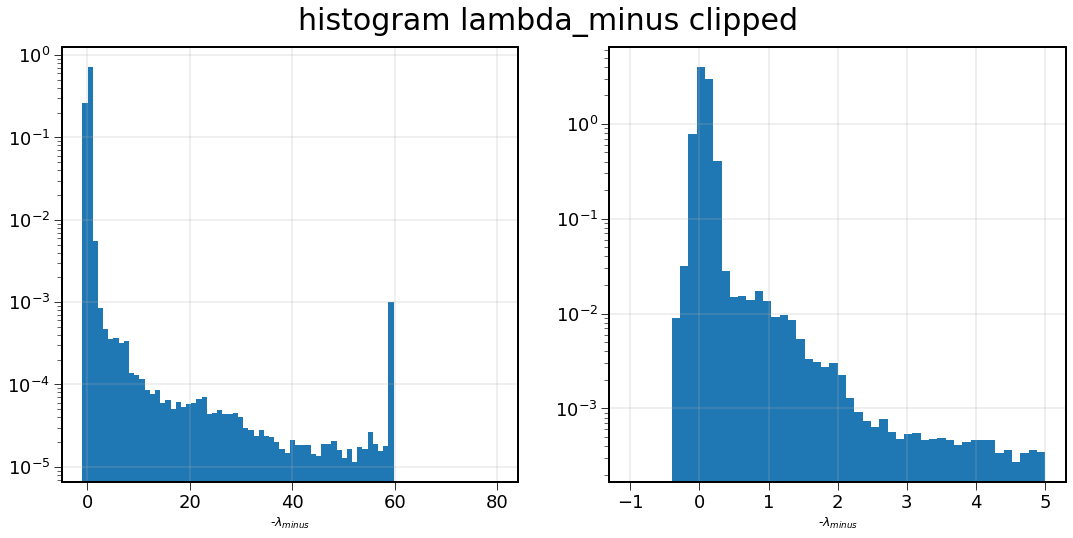

In [146]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.hist(-lambda_minus.flatten(),bins=80,range=(-1,80),normed='True');
plt.yscale('log')
plt.xlabel('-$\lambda_{minus}$')
plt.grid()
plt.subplot(1,2,2)
plt.hist(-lambda_minus.flatten(),bins=50,range=(-1,5),normed='True');
plt.yscale('log')
plt.xlabel('-$\lambda_{minus}$')
plt.grid()
plt.suptitle("histogram "+ main_title ,fontsize=30,y=.95)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 0.999, 'histogram lambda_minus clipped')

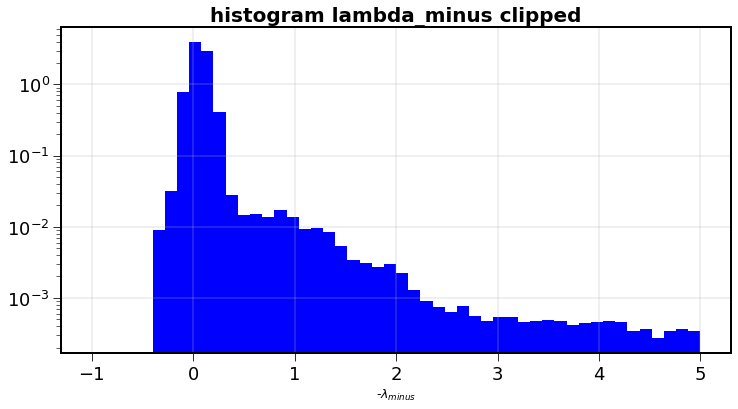

In [147]:
plt.figure(figsize=(12,6))
hist_data=plt.hist(-lambda_minus.flatten(),bins=50,range=(-1,5),normed='True',facecolor='b');
plt.yscale('log')
plt.grid()
plt.xlabel('-$\lambda_{minus}$')
plt.title("histogram "+ main_title ,fontsize=20,y=.999)

In [148]:
logcount,binval=np.log10(hist_data[0]),hist_data[1]

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [149]:
logcount.shape

(50,)

In [150]:
binval.shape

(51,)

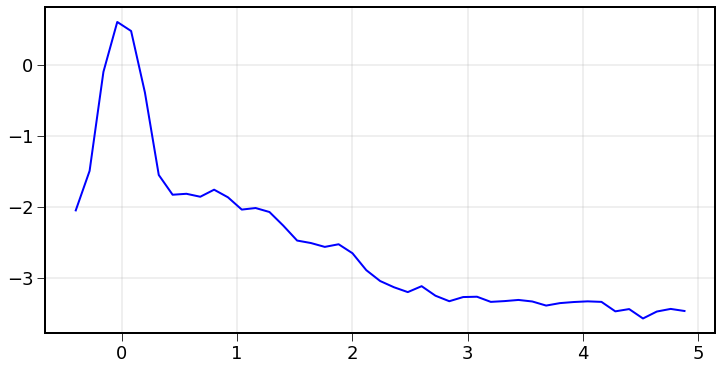

In [151]:
plt.figure(figsize=(12,6))
plt.plot(binval[:-1],logcount,'b-')
plt.grid()
#plt.xlim(-1,5)

In [152]:
find_peaks(logcount)

(array([ 8, 13, 15, 18, 24, 30, 34, 37, 42, 45, 48]), {})

# algo


https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py

https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py

## Sobel algorithm

- The Sobel algorithm has the advantage of not having any threshold to tune

In [153]:
edges= sobel(lambda_minus) 

In [154]:
#sobel?

Text(0.5, 0.8, 'Sobel lambda_minus clipped')

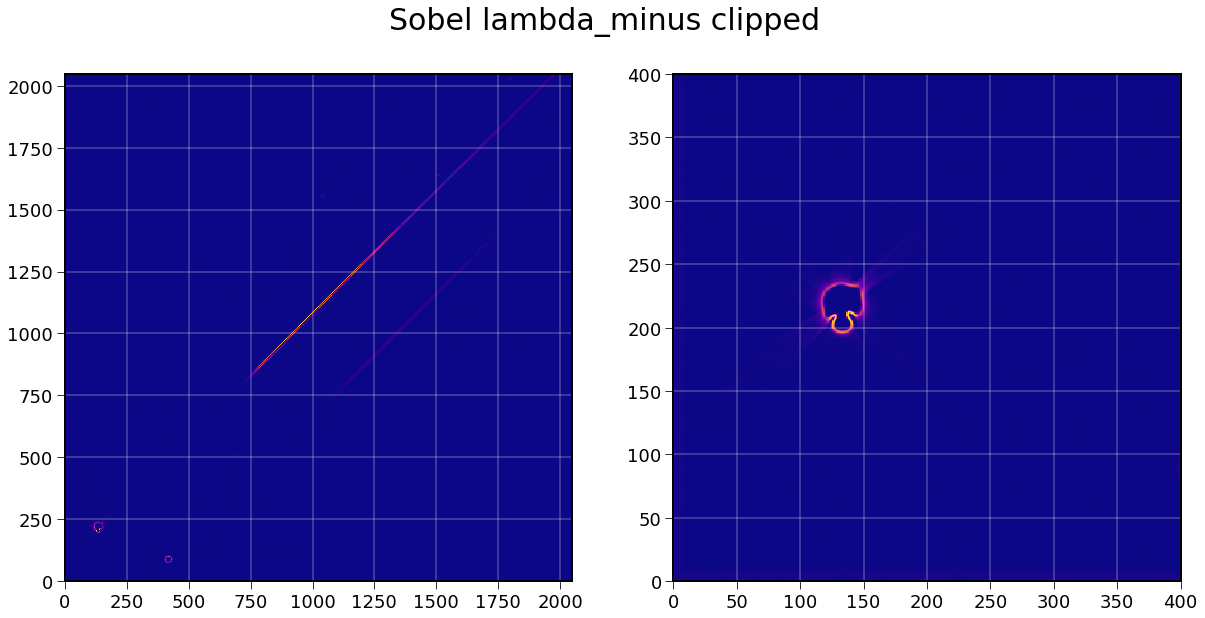

In [155]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(edges,origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
plt.imshow(edges,origin="lower",cmap=plt.cm.plasma)
plt.xlim(0,400)
plt.ylim(0,400)
plt.grid(color="w")
plt.suptitle("Sobel "+ main_title ,fontsize=30,y=.8)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 0.95, 'Sobel histogram lambda_minus clipped')

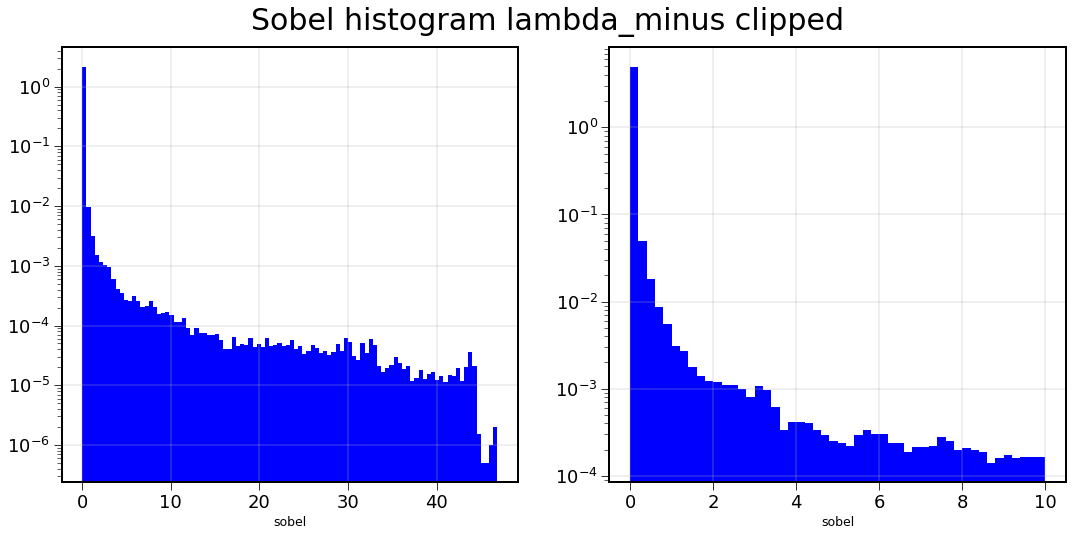

In [156]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.hist(edges.flatten(),bins=100,normed='True',facecolor='b')
plt.yscale('log')
plt.xlabel('sobel')
plt.grid()
plt.subplot(1,2,2)
plt.hist(edges.flatten(),bins=50,range=(0,10),normed='True',facecolor="b")
plt.yscale('log')
plt.xlabel('sobel')
plt.grid()
plt.suptitle("Sobel histogram "+ main_title ,fontsize=30,y=.95)

In [157]:
markers = np.zeros_like(edges)
markers[edges >= 0 ] = 0
markers[edges >= 1 ] = 1   # all points for markers = 0 or 1 will be erased
markers[edges >  4 ] = 2    # all point above this threshold wil be kept
markers[edges > 10 ] = 3
markers[edges > 20] = 4
markers[edges > 30] = 5

Text(0.5, 0.8, 'Markers for Sobel edge')

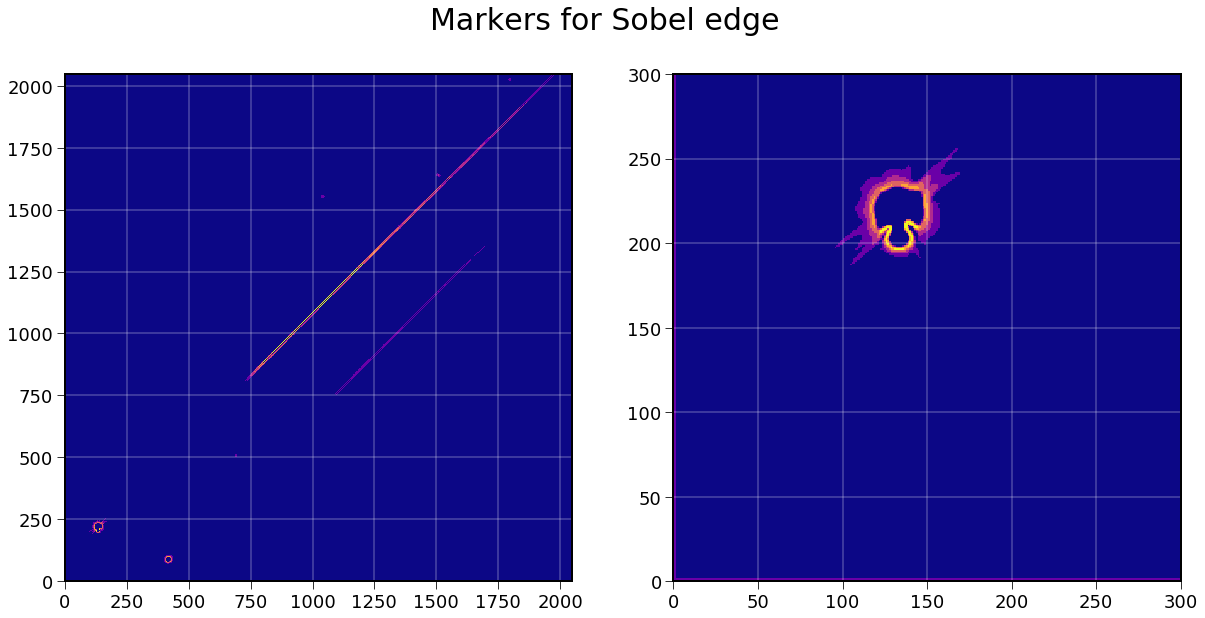

In [158]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(markers, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
plt.imshow(markers,origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.xlim(0,300)
plt.ylim(0,300)
plt.suptitle("Markers for Sobel edge" , fontsize=30,y=.8)

## Masking in slices of lambda

- Use -lambda_minus to defines markers

In [159]:
#markers = np.zeros_like(lambda_minus)
#markers[-lambda_minus >=0 ] = 0
#markers[-lambda_minus >=0.1 ] = 1   # all points for markers = 0 or 1 will be erased
#markers[-lambda_minus > 0.5] = 2    # all point above this threshold wil be kept
#markers[-lambda_minus > 10] = 3
#markers[-lambda_minus > 30] = 4

In [160]:
markers = np.zeros_like(lambda_minus)
markers[-lambda_minus >=0 ] = 0
markers[-lambda_minus >=0.1 ] = 1   # all points for markers = 0 or 1 will be erased
markers[-lambda_minus > 0.5] = 2    # all point above this threshold wil be kept
markers[-lambda_minus > 2 ] = 3
markers[-lambda_minus > 10] = 4
markers[-lambda_minus > 30] = 5

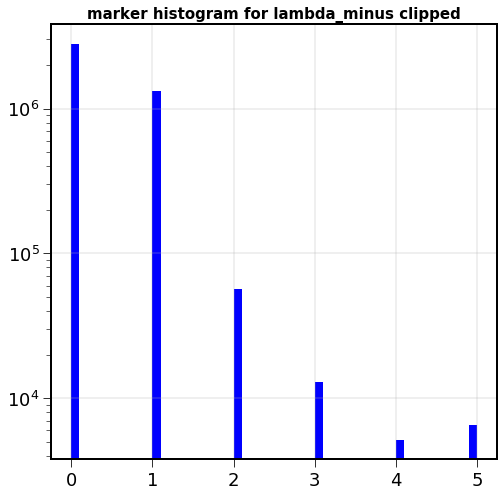

In [161]:
plt.hist(markers.flatten(),bins=50,facecolor='b')
plt.yscale('log')
plt.title("marker histogram for "+ main_title )
plt.grid()

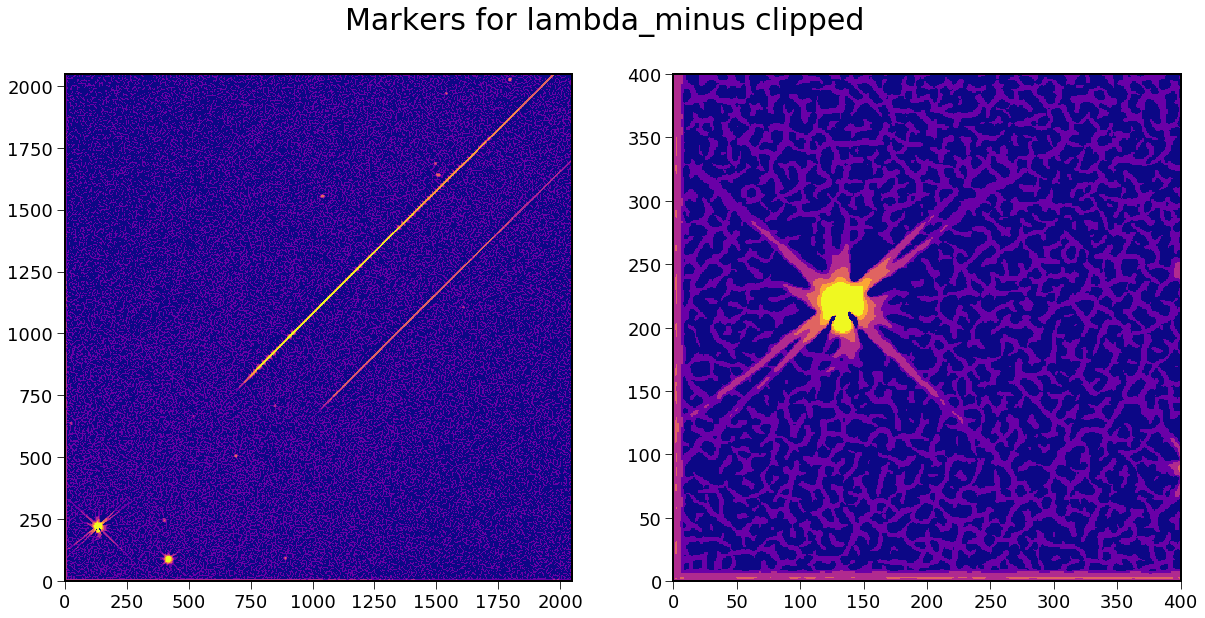

In [162]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(markers, origin="lower",cmap=plt.cm.plasma)
plt.subplot(1,2,2)
plt.imshow(markers,origin="lower",cmap=plt.cm.plasma)
plt.xlim(0,400)
plt.ylim(0,400)
plt.grid(color="w")
plt.suptitle("Markers for "+ main_title , fontsize=30,y=.8)
plt.grid()

## Segmentation with watershed

- use Sobel + Markers

In [163]:
segmentation = morphology.watershed(edges, markers)

Text(0.5, 0.8, 'Sobel segmentation with markers for  lambda_minus clipped')

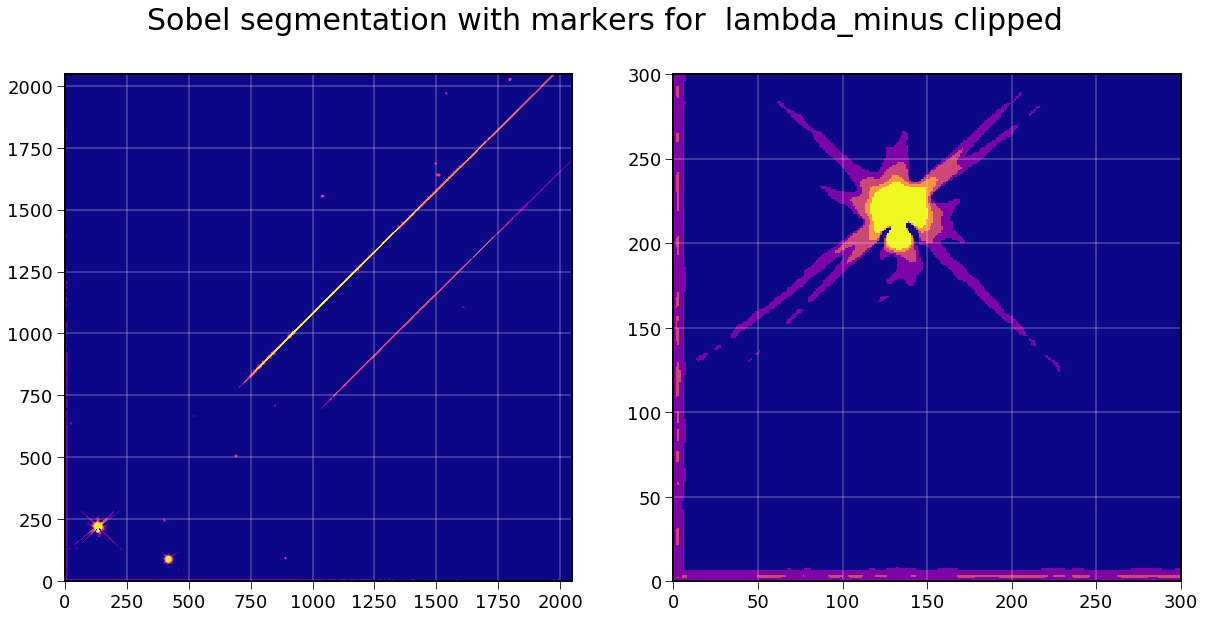

In [164]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(segmentation, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
plt.imshow(segmentation,origin="lower",cmap=plt.cm.plasma)
plt.xlim(0,300)
plt.ylim(0,300)
plt.grid(color="w")
plt.suptitle("Sobel segmentation with markers for  "+ main_title , fontsize=30,y=.8)

Text(0.5, 1.0, 'histogram of segmentation for lambda_minus clipped')

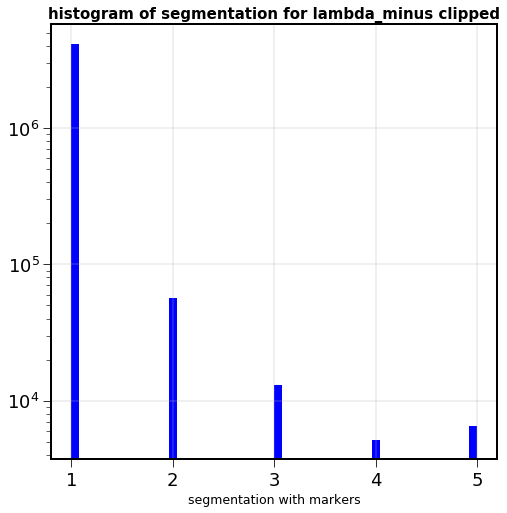

In [165]:
plt.hist(segmentation.flatten(),bins=50,facecolor='b')
plt.yscale('log')
plt.grid()
plt.xlabel('segmentation with markers')
plt.title("histogram of segmentation for " +main_title)

## Selection of Aigrettes

In [166]:
selection = np.where(segmentation==2,1,0)

Text(0.5, 0.8, 'aigrette segmentation with markers for  lambda_minus clipped')

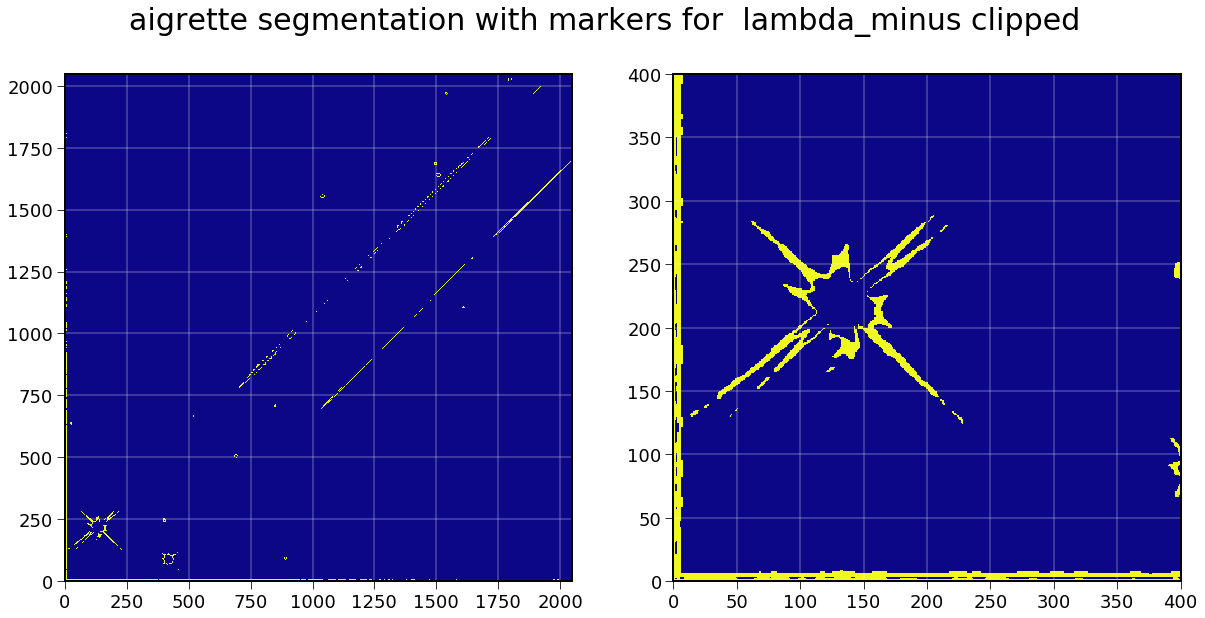

In [167]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
#plt.imshow(selection, origin="lower",cmap=plt.cm.jet)
plt.imshow(selection, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
#plt.imshow(selection,origin="lower",cmap=plt.cm.jet)
plt.imshow(selection,origin="lower",cmap=plt.cm.plasma)
plt.xlim(0,400)
plt.ylim(0,400)
plt.grid(color="w")
plt.suptitle("aigrette segmentation with markers for  "+ main_title , fontsize=30,y=.8)

# clean borders

In [168]:
margin=10

In [169]:
selection[:margin,:]=0
selection[-margin:,:]=0
selection[:,:margin]=0
selection[:,-margin:]=0

Text(0.5, 0.8, 'aigrette segmentation with markers and cleaned for  lambda_minus clipped')

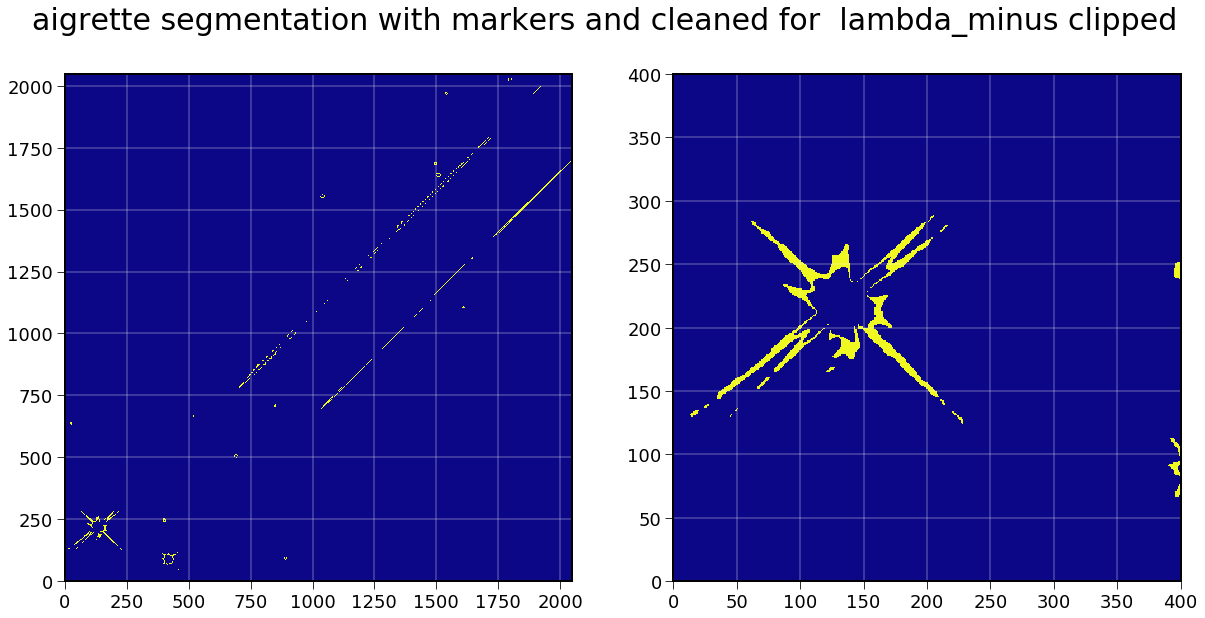

In [170]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
#plt.imshow(selection, origin="lower",cmap=plt.cm.jet)
plt.imshow(selection, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
#plt.imshow(selection,origin="lower",cmap=plt.cm.jet)
plt.imshow(selection,origin="lower",cmap=plt.cm.plasma)
plt.xlim(0,400)
plt.ylim(0,400)
plt.grid(color="w")
plt.suptitle("aigrette segmentation with markers and cleaned for  "+ main_title , fontsize=30,y=.8)

# Hough Line Detection

In [171]:
theta_deg=np.arange(-90,91,0.25)

In [172]:
theta_rad=np.radians(theta_deg)

In [173]:
NBAng=len(theta_rad)

In [174]:
aigrettes = selection[:300,:300]

In [175]:
# vector containing the points of aigrettes
Y,X=np.where(aigrettes==1)

In [176]:
NBPoints=len(X)

In [177]:
NBPoints

2891

(0, 500)

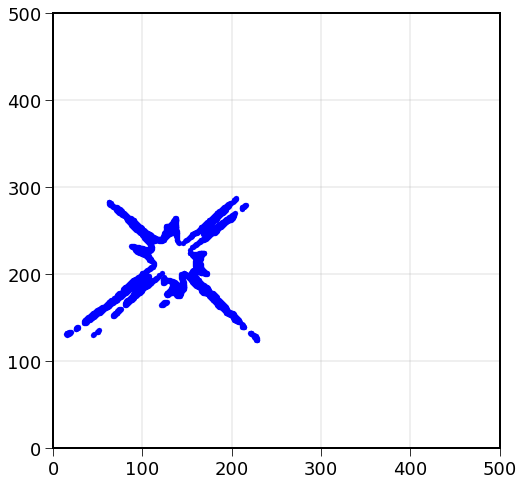

In [178]:
plt.plot(X,Y,"b.")
plt.grid()
plt.xlim(0,500)
plt.ylim(0,500)

## calculate hough data

- array number of points x nb of angles

In [179]:
NBRHOBIN=int(aigrettes.shape[0]/2)
RHOMIN=-aigrettes.shape[0]
RHOMAX=aigrettes.shape[0]

### Bins functions

In [180]:
def getbin(x):
    """
    
    getbin(x):
     from a vector of rhos from, give the corresponding rhos - bin index and return the count number
    
    """
    fraction = (x/RHOMAX+1)*NBRHOBIN/2 
    ibins = fraction.astype(int)  
    ibins = np.where(np.logical_and(ibins>=0,ibins<NBRHOBIN),ibins,-1)
    
    uniquebins,countbins= np.unique(ibins,return_counts=True)
    
    badindexes=np.where(uniquebins==-1)
    keepbins=np.delete(uniquebins,badindexes)
    keepcounts = np.delete(countbins,badindexes)
    
    return keepbins,keepcounts

In [181]:
def getrho(ibin):
    return (ibin-NBRHOBIN/2.)/(NBRHOBIN/2.)*RHOMAX

### Arrays for storing

In [182]:
hough_data=np.zeros((NBPoints,NBAng))
hough_accumulator = np.zeros((NBRHOBIN,NBAng))

## Compute r (or rho) for each point and angle

In [183]:
# fill hough data givin the r for each point
# loop on angles to fill hough_data
for iang in np.arange(NBAng):
    costh=np.cos(theta_rad[iang])
    sinth=np.sin(theta_rad[iang])
    # compute rho for each point (x,y)
    rho = X*costh+Y*sinth 
    hough_data[:,iang] = rho
    
    # fill the accumulator :
    # search in which rho-bin the points should be attributed 
    thebins,thecounts=getbin(rho)
    
    for ibin in np.arange(len(thebins)):
        hough_accumulator[thebins[ibin],iang] = hough_accumulator[thebins[ibin],iang] + thecounts[ibin]


## Plot Hough line space

### Plot Hough Line space 2D

In [184]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NBPoints)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBPoints), alpha=1)

Text(0, 0.5, '$\\rho$ (pixel)')

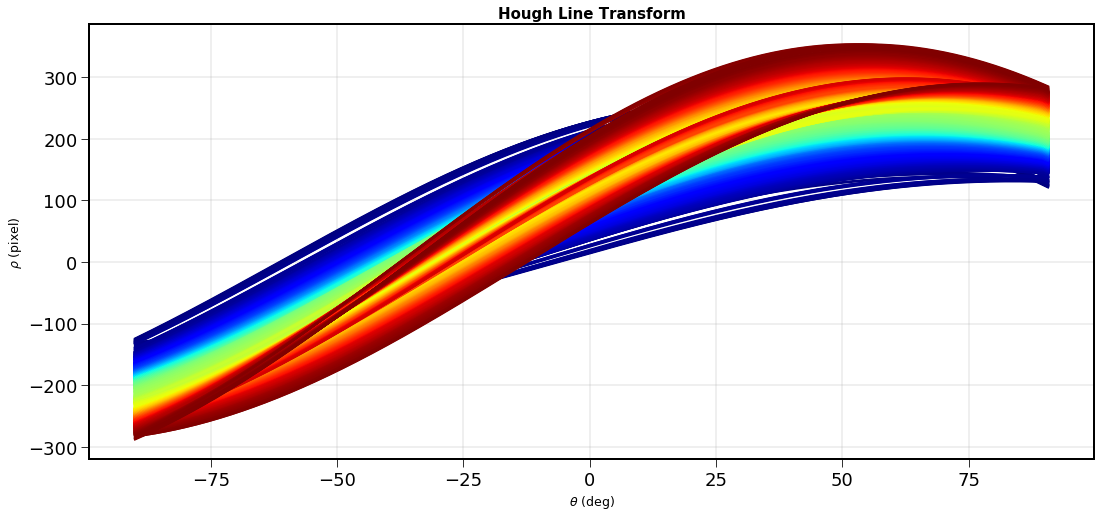

In [185]:
# loop on angles
plt.figure(figsize=(18,8))

for ipoint in np.arange(NBPoints):    
    plt.plot(theta_deg,hough_data[ipoint,:],"-",color=all_colors[ipoint])
    
plt.grid()
plt.title("Hough Line Transform")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")

### Show Hough line histogram

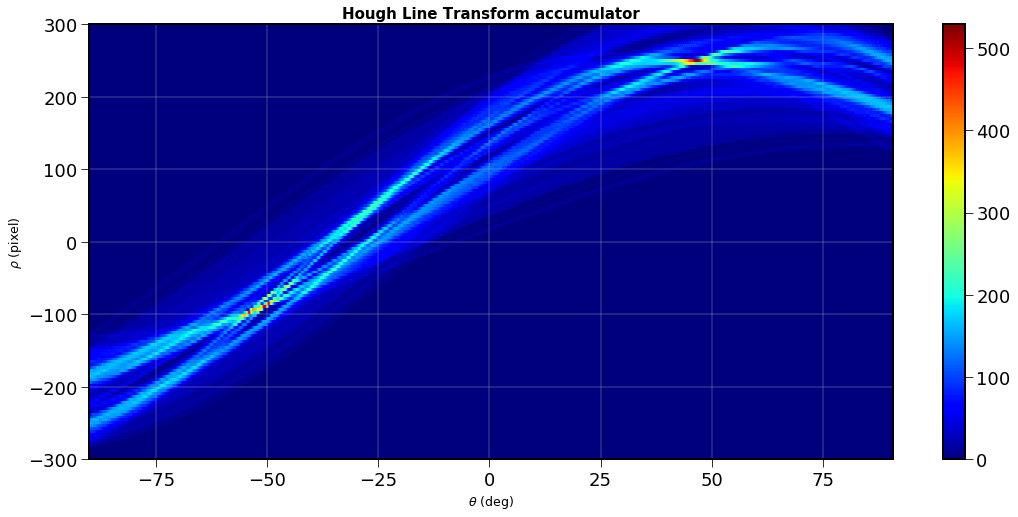

In [186]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.grid()
plt.title("Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar(im)

### Statistic in Hough line space

Text(0, 0.5, 'number of bins')

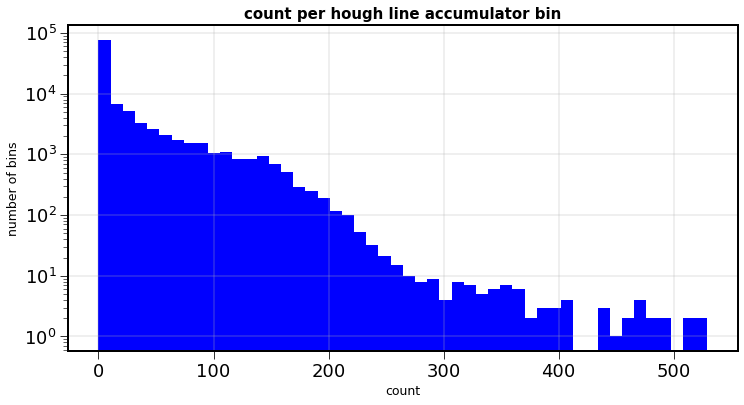

In [187]:
plt.figure(figsize=(12,6))
hist_data=plt.hist(hough_accumulator.flatten(),bins=50,facecolor="b")
plt.yscale("log")
plt.title("count per hough line accumulator bin")
plt.grid()
plt.xlabel("count")
plt.ylabel("number of bins")

In [188]:
count,bin_val=np.log10(hist_data[0]), hist_data[1]

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


### Selected accumulation

In [189]:
ipeak_y,ipeak_x=np.where(hough_accumulator>430)

In [190]:
YY=getrho(ipeak_y)
XX=theta_deg[ipeak_x]

In [191]:
selected_rhos=YY
selected_thetas=XX

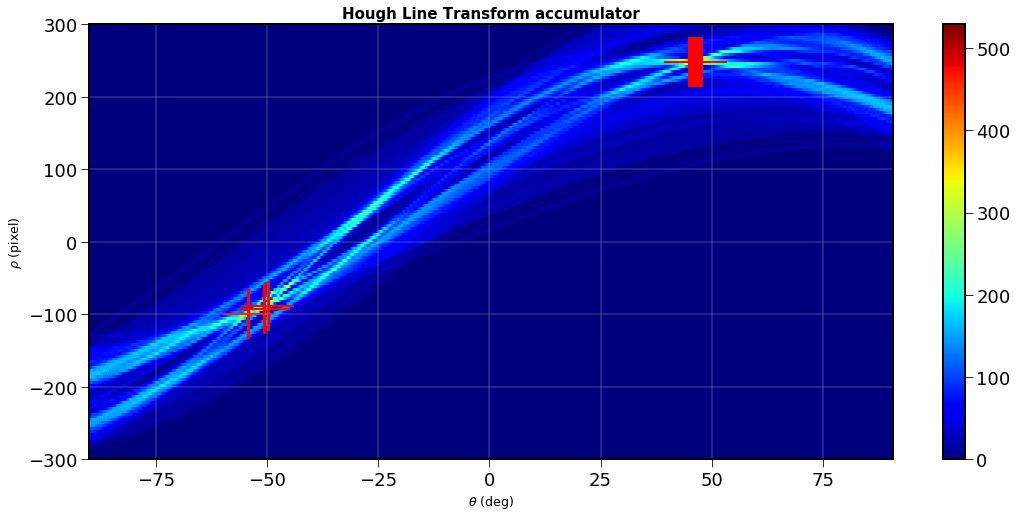

In [192]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.scatter(XX,YY, c='r', marker='+',s=50**2)
plt.grid()
plt.title("Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar(im)

### Filtered Hough line accumulator

In [193]:
hough_accumulator_filt=gaussian(hough_accumulator,sigma=[1,1])

In [194]:
hough_accumulator_filt.shape

(150, 724)

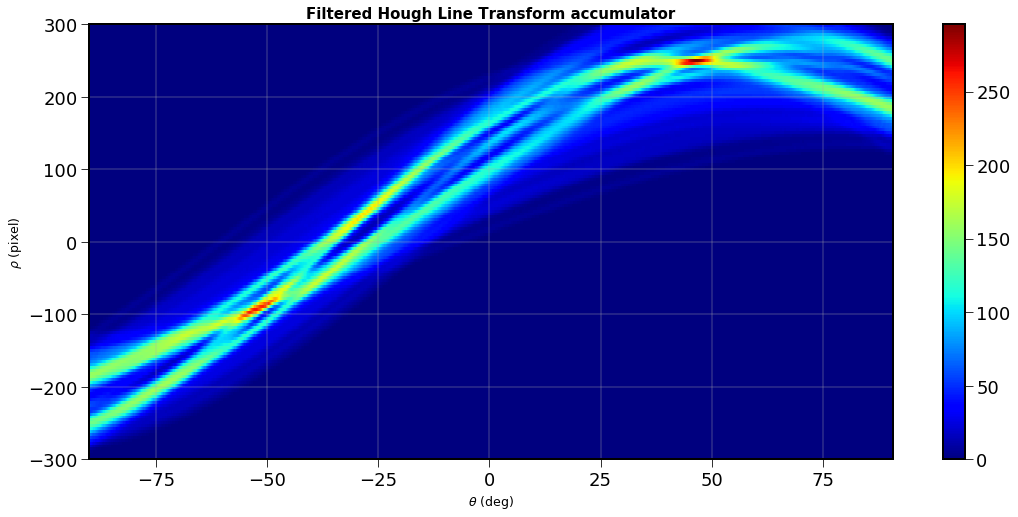

In [195]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator_filt,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.grid()
plt.title("Filtered Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar()

### Statistic for filttered accumulator

Text(0, 0.5, 'number of bins')

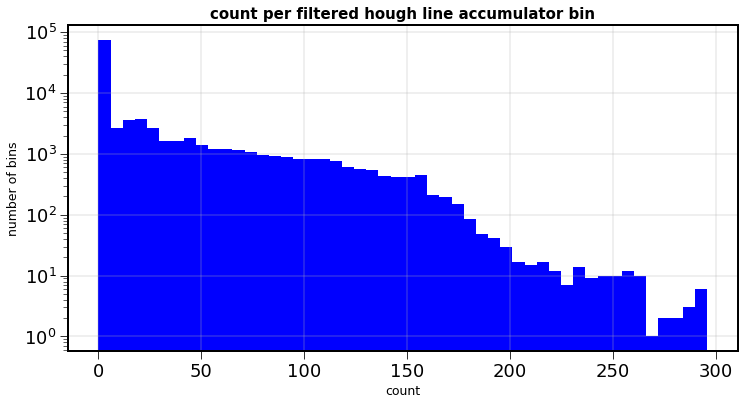

In [196]:
plt.figure(figsize=(12,6))
plt.hist(hough_accumulator_filt.flatten(),bins=50,facecolor="b")
plt.yscale("log")
plt.title("count per filtered hough line accumulator bin")
plt.grid()
plt.xlabel("count")
plt.ylabel("number of bins")

### Plot selected points in filtered accumulator

In [197]:
#ipeak_y,ipeak_x=np.where(hough_accumulator_filt>275)
ipeak_y,ipeak_x=np.where(hough_accumulator_filt>260)

In [198]:
YY=getrho(ipeak_y)
XX=theta_deg[ipeak_x]

In [199]:
len(XX)

24

In [200]:
selected_rhos=YY
selected_thetas=XX
selected_ipeak_rhos = ipeak_y
selected_ipeak_angles = ipeak_x

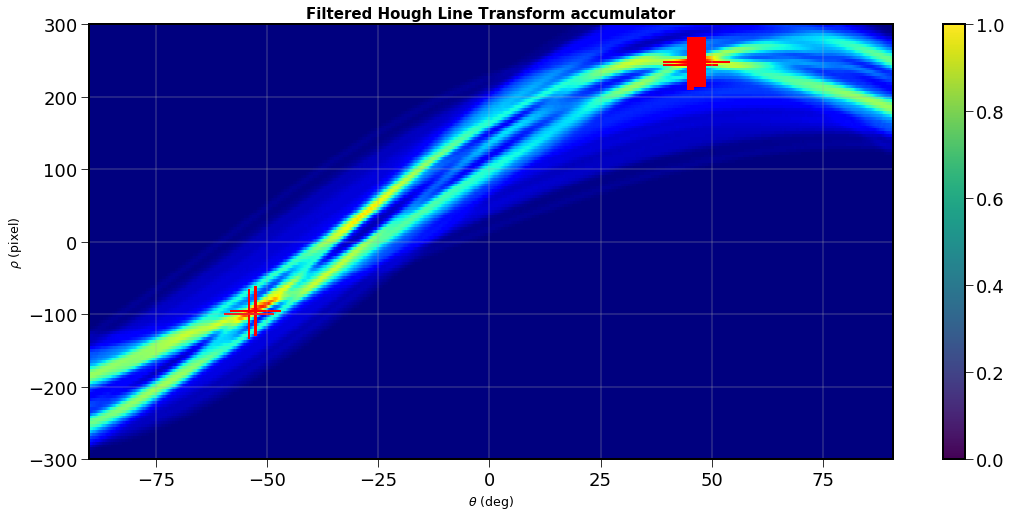

In [201]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator_filt,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.scatter(XX,YY, c='r', marker='+',s=50**2)
plt.grid()
plt.title("Filtered Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar()

# Draw aigrettes

In [202]:
len(selected_rhos)

24

In [203]:
selected_rhos

array([-100.,  -96.,  -96.,  244.,  244.,  244.,  244.,  244.,  248.,
        248.,  248.,  248.,  248.,  248.,  248.,  248.,  248.,  248.,
        248.,  248.,  248.,  248.,  248.,  248.])

In [204]:
selected_thetas

array([-54.  , -52.75, -52.5 ,  44.75,  45.  ,  45.25,  45.5 ,  45.75,
        44.75,  45.  ,  45.25,  45.5 ,  45.75,  46.  ,  46.25,  46.5 ,
        46.75,  47.  ,  47.25,  47.5 ,  47.75,  48.  ,  48.25,  48.5 ])

In [205]:
NSEG=len(selected_rhos)

In [206]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.8, 'Fit of aigrettes from lambda_minus clipped')

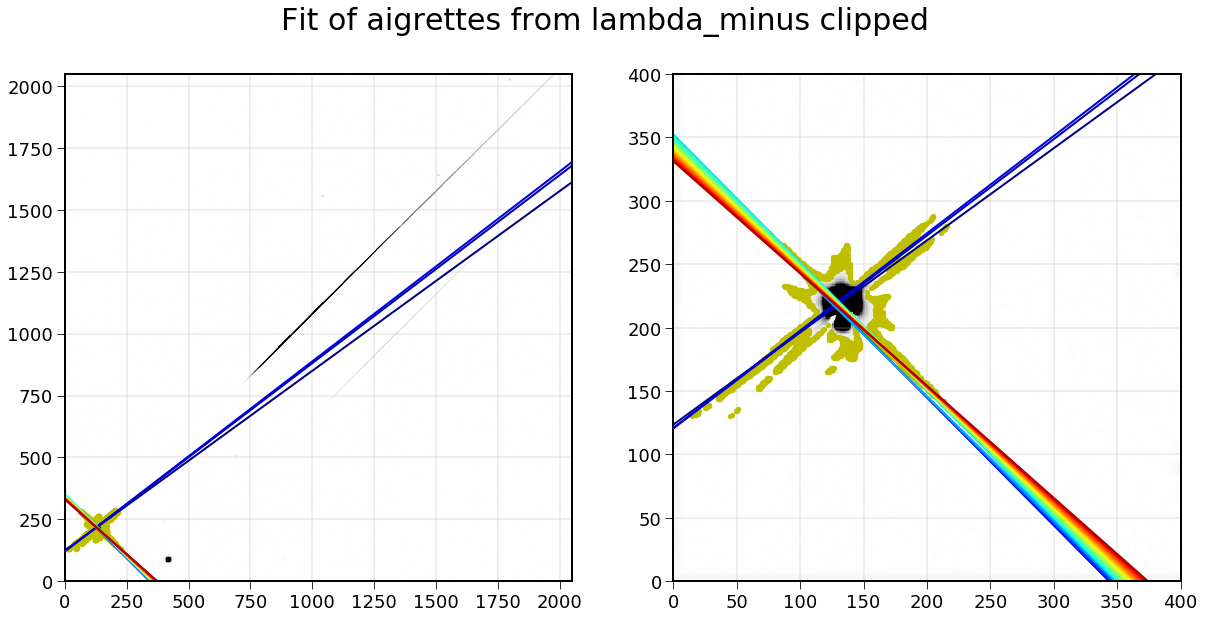

In [207]:
XMIN1=0
XMAX1=lambda_minus.shape[1]
YMIN1=0
YMAX1=lambda_minus.shape[0]

XMIN2=0
XMAX2=400
YMIN2=0
YMAX2=400

# figure 1
fig=plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray")

plt.plot(X,Y,".",color='y')
#plt.grid()

X1=np.arange(XMIN1,XMAX1)
for index in np.arange(NSEG):
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    XH=rho*np.cos(theta)
    YH=rho*np.sin(theta)
    slope=-np.tan(np.pi/2-theta)
    
    Y1=-np.tan(np.pi/2-theta)*X1+rho/np.sin(theta)
    #Y1=slope*(X1-XH)+YH
    plt.plot(X1,Y1,'-',color=all_colors[index])
    #plt.scatter([XH],[YH], c=all_colors[index], marker='+',s=50**2)

plt.grid()
plt.xlim(XMIN1,XMAX1)
plt.ylim(YMIN1,YMAX1)


# figure 2
plt.subplot(1,2,2)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray")

plt.plot(X,Y,".",color='y')

X2=np.arange(XMIN2,XMAX2)
for index in np.arange(NSEG):
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    XH=rho*np.cos(theta)
    YH=rho*np.sin(theta)
    slope=-np.tan(np.pi/2-theta)
    
    Y2=-np.tan(np.pi/2-theta)*X2+rho/np.sin(theta)
    #Y2=slope*(X2-XH)+YH
    plt.plot(X2,Y2,'-',color=all_colors[index])

plt.xlim(XMIN2,XMAX2)
plt.ylim(YMIN2,YMAX2)
plt.grid()
title="Fit of aigrettes from "+ main_title
plt.suptitle(title,fontsize=30,y=.8)



In [208]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Zoom on Fit of aigrettes from lambda_minus clipped')

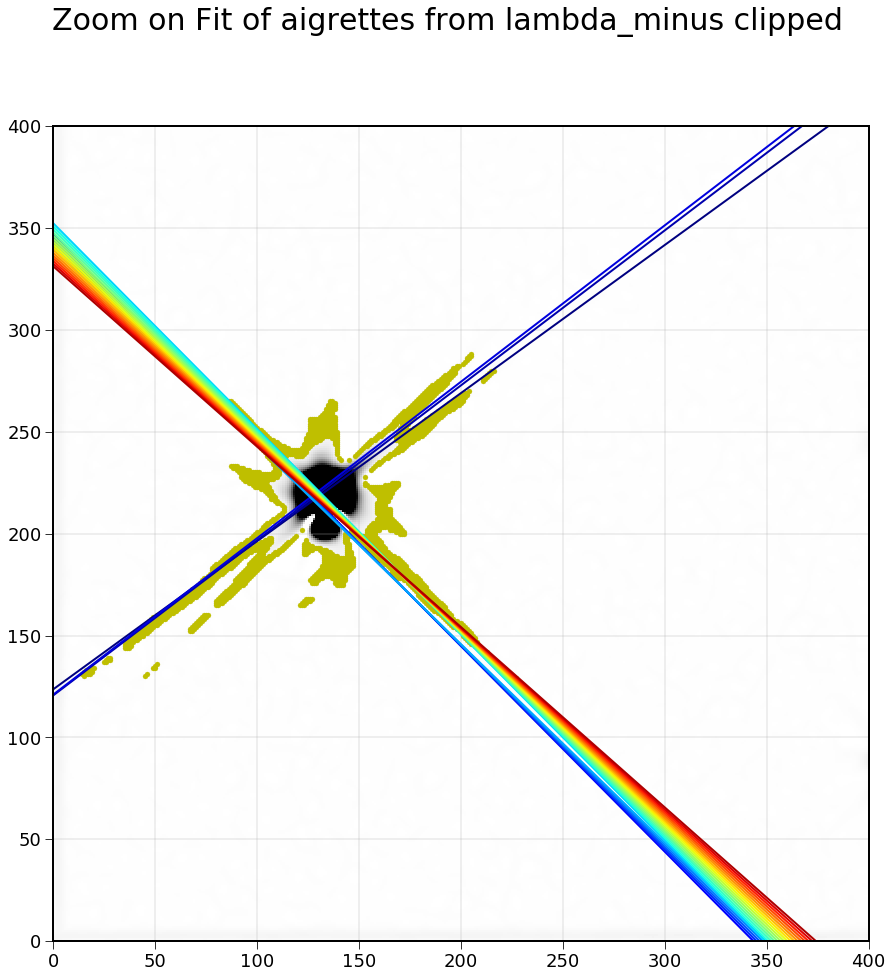

In [209]:
# figure 3

XMIN3=0
XMAX3=400
YMIN3=0
YMAX3=400


plt.figure(figsize=(15,15))

img=plt.imshow(lambda_minus,origin="lower",cmap="gray")

plt.plot(X,Y,".",color='y')

X3=np.arange(XMIN3,XMAX3)
for index in np.arange(NSEG):
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    XH=rho*np.cos(theta)
    YH=rho*np.sin(theta)
    slope=-np.tan(np.pi/2.0-theta)
    
    Y3=-np.tan(np.pi/2-theta)*X3+rho/np.sin(theta)
    #Y3=slope*(X3-XH)+YH
    plt.plot(X3,Y3,'-',color=all_colors[index])

plt.xlim(XMIN3,XMAX3)
plt.ylim(YMIN3,YMAX3)
plt.grid()
title="Zoom on Fit of aigrettes from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)


## find original points of aigrettes 

In [210]:
selected_ipeak_rhos

array([ 50,  51,  51, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137,
       137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137])

In [211]:
# container of point indexes for each segments
all_segments_indexes = []

# loop on the selected segments
for index in np.arange(NSEG):
    
    # angle and rho of the selected segment     
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    costh=np.cos(theta)
    sinth=np.sin(theta)
    
    # find the bin indexes in hough space
    ipeak_x_sel=selected_ipeak_angles[index]
    ipeak_y_sel=selected_ipeak_rhos[index]
    
    # container of points for that segments
    points_indexes_segments = []
    
   
    # compute rho for each point (x,y)
    rho = X*costh+Y*sinth 
    
    fraction = (rho/RHOMAX+1)*NBRHOBIN/2 
    ibins = fraction.astype(int)  
    ibins = np.where(np.logical_and(ibins>=0,ibins<NBRHOBIN),ibins,-1)
    
    # find the points identifiers 
    selected_points = np.where(ibins == ipeak_y_sel)[0]
      
    all_segments_indexes.append(selected_points)
   

In [212]:
len(all_segments_indexes) 

24

In [213]:
lambda_plus=np.copy(image.img_cube[parameters.IndexImg.lambda_plus_clip])
original=np.copy(image.img_cube[parameters.IndexImg.img_clip]) 

In [214]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Zoom on aigrettes points from lambda_minus clipped')

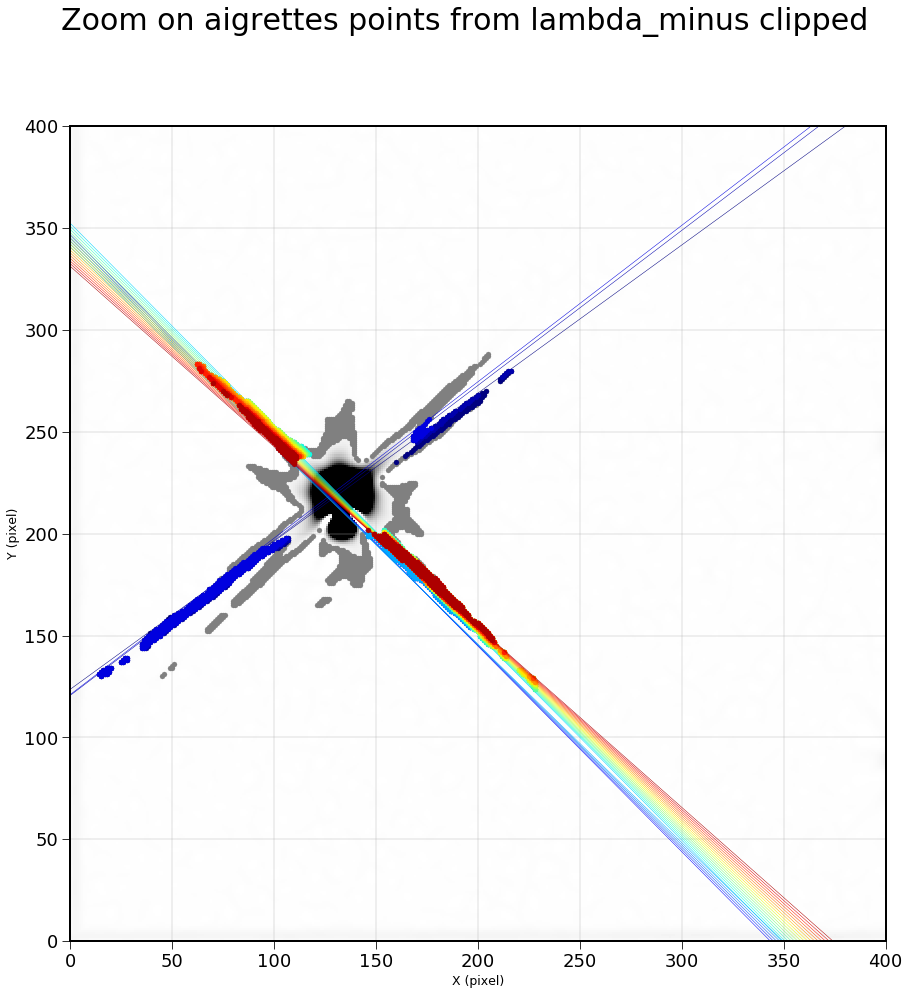

In [215]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")
plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    Y4=-np.tan(np.pi/2-theta)*X4+rho/np.sin(theta)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Zoom on aigrettes points from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)
  

In [216]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Aigrettes points from lambda_minus clipped $\\lambda$+ at center')

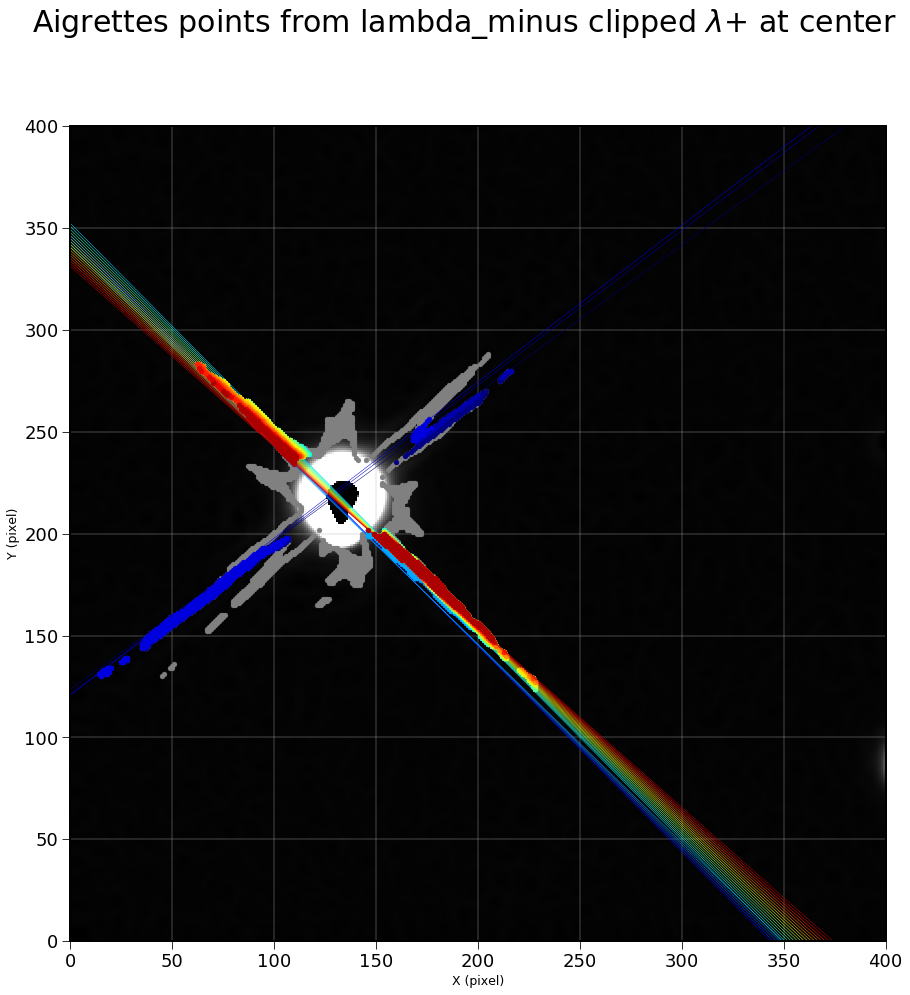

In [217]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
img=plt.imshow(lambda_plus,origin="lower",cmap="gray")
plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    Y4=-np.tan(np.pi/2-theta)*X4+rho/np.sin(theta)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Aigrettes points from "+ main_title + " $\\lambda$+ at center"
plt.suptitle(title,fontsize=30,y=.99)
  

In [218]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Aigrettes points from lambda_minus clipped original image bg')

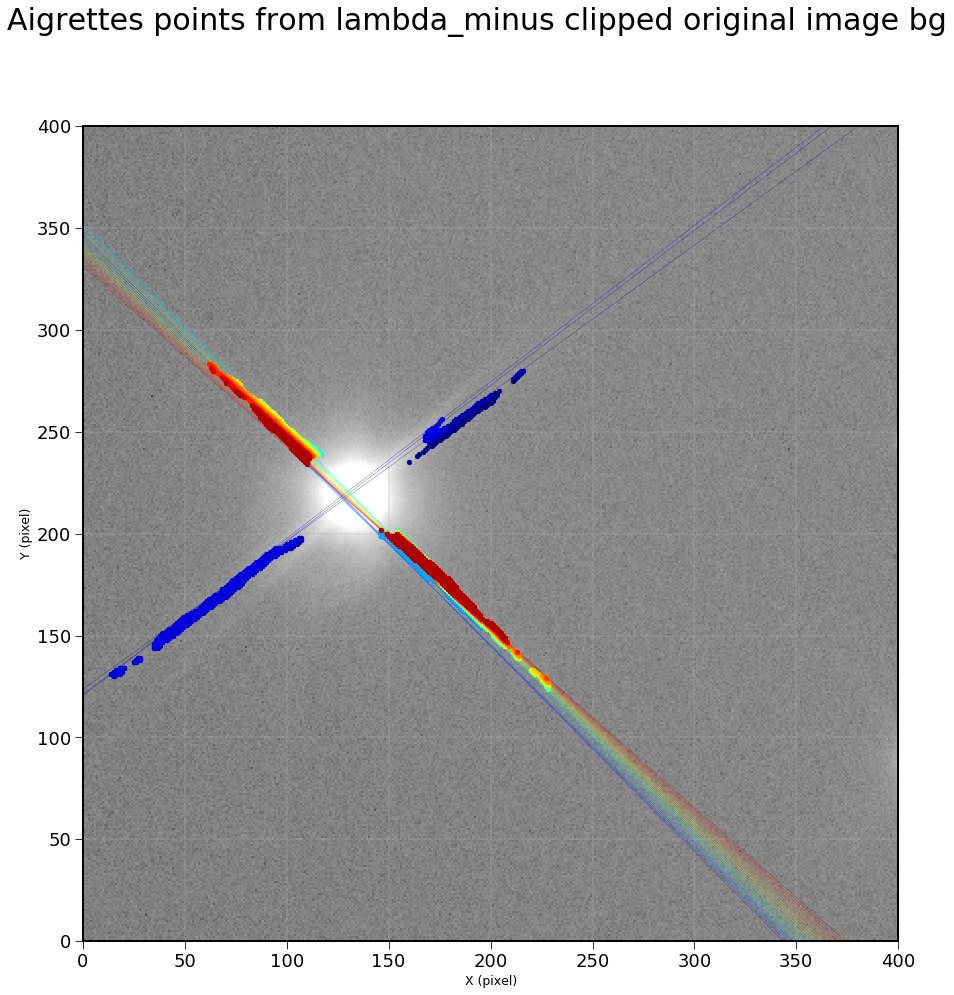

In [219]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
vmin=original.flatten().min()
vmax=original.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")
#plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index],lw=0.25)

    
    # plot lines
    Y4=-np.tan(np.pi/2-theta)*X4+rho/np.sin(theta)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.25)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Aigrettes points from "+ main_title + " original image bg"
plt.suptitle(title,fontsize=30,y=.99)
  

# Fit  straight lines for each segment from its points

## Extract weight

In [220]:
W = np.zeros(NBPoints)
for ipoint in list_of_points_indexes:
    thex=X[ipoint]
    they=Y[ipoint]
    #W[ipoint] = original[they,thex]
    W[ipoint] = -lambda_minus[they,thex]

In [221]:
W.max()

1.988449831913215

Text(0.5, 1.0, 'weight of aigrette pixels in original image ')

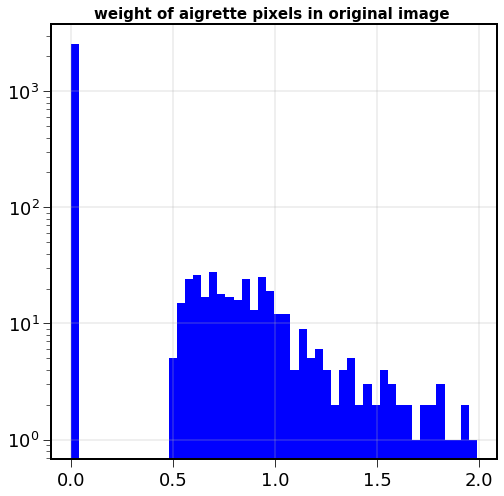

In [222]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.hist(W,bins=50,range=(0,500),facecolor="b")
ax.hist(W,bins=50,facecolor="b")
ax.set_yscale('log',basey=10)
ax.grid()
ax.set_title("weight of aigrette pixels in original image ")

In [223]:
jet = plt.get_cmap('gray')
plasma=plt.cm.plasma
cNorm = mpl.colors.Normalize(vmin=0, vmax=NBPoints)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)
all_colors = scalarMap.to_rgba(np.arange(NBPoints), alpha=1)

(0, 500)

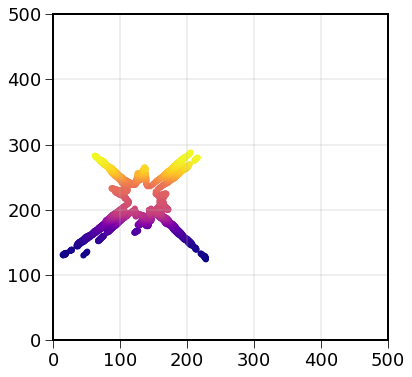

In [224]:
plt.figure(figsize=(6,6))
plt.scatter(X,Y,c=all_colors,marker=".")
plt.grid()
plt.xlim(0,500)
plt.ylim(0,500)

## Orthogonal distance regression : fit a straight line

https://docs.scipy.org/doc/scipy/reference/odr.html#id1


In [225]:
index=0 
list_of_points_indexes = all_segments_indexes[index]  
X_inseg=X[list_of_points_indexes].astype('float')
Y_inseg=Y[list_of_points_indexes].astype('float')
SX_inseg=np.ones(len(X_inseg))
SY_inseg=np.ones(len(X_inseg))

In [226]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [227]:
linear = odr.Model(f)

In [228]:
data = odr.Data(X_inseg, Y_inseg, wd=1./np.power(SX_inseg,2), we=1./np.power(SX_inseg,2))

In [229]:
myodr = odr.ODR(data, linear, beta0=[1., 2.])

In [230]:
myoutput = myodr.run()

In [231]:
myoutput.pprint()

Beta: [  0.72857237 120.74976246]
Beta Std Error: [0.00100529 0.12497848]
Beta Covariance: [[ 8.72701429e-07 -9.46504396e-05]
 [-9.46504396e-05  1.34882616e-02]]
Residual Variance: 1.1580157740148982
Inverse Condition #: 0.0039195898105529895
Reason(s) for Halting:
  Sum of squares convergence


In [232]:
myoutput.beta

array([  0.72857237, 120.74976246])

In [233]:
myoutput.sd_beta

array([0.00100529, 0.12497848])

In [234]:
myoutput.cov_beta

array([[ 8.72701429e-07, -9.46504396e-05],
       [-9.46504396e-05,  1.34882616e-02]])

In [235]:
#myoutput?

In [236]:
parameters = []
Npts = []

for index in np.arange(NSEG):
       
    # extract points for each segments
    list_of_points_indexes = all_segments_indexes[index]  
    Ninseg=len(list_of_points_indexes)
    #print(" -------------------   segment ",index," Nbpoint = ",Ninseg," ----------------------------------")
    
    X_inseg=X[list_of_points_indexes].astype('float')
    Y_inseg=Y[list_of_points_indexes].astype('float')
    SX_inseg=np.ones(len(X_inseg))
    SY_inseg=np.ones(len(X_inseg))
    
    # do the orthogonal fit
    data = odr.Data(X_inseg, Y_inseg, wd=1./np.power(SX_inseg,2), we=1./np.power(SX_inseg,2))
    myodr = odr.ODR(data, linear, beta0=[1., 2.])
    myoutput = myodr.run()
    #myoutput.pprint()
    parameters.append(myoutput.beta)
    Npts.append(Ninseg)

In [237]:
parameters = np.array(parameters)
Npts = np.array(Npts)

In [238]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Fitted Aigrettes lines from lambda_minus clipped')

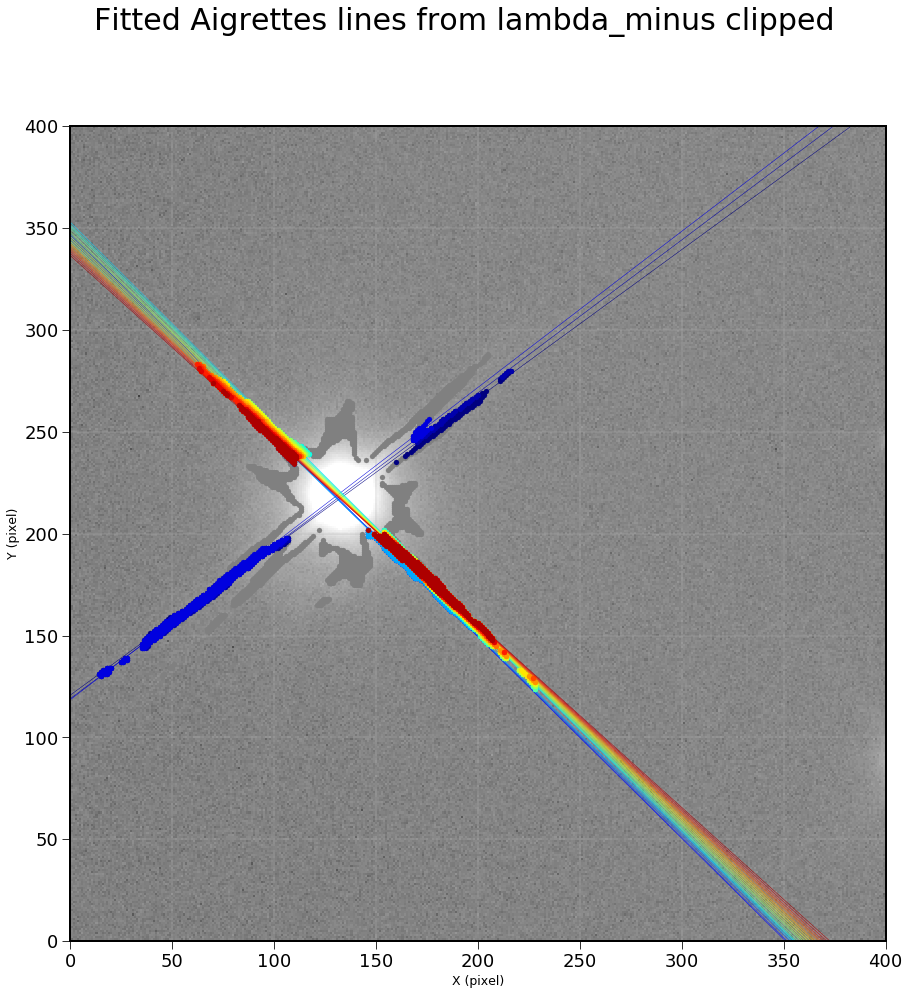

In [239]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

vmin=original.flatten().min()
vmax=original.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)
  

# Fit central point

In [240]:
# loop on the selected segmentsfor index in np.arange(NSEG):
VX1=np.zeros(NSEG)
VX2=np.zeros(NSEG)
VY1=np.zeros(NSEG)
VY2=np.zeros(NSEG)
for index in np.arange(NSEG):
    
    VX1[index]=X4.min()
    VX2[index]=X4.max()
    
    B=parameters[index]
 
    VY1[index]=f(B, X4.min())
    VY2[index]=f(B, X4.max())
   

In [241]:
X0,Y0,sigX0,sigY0,covXY=fit_centralPoint2(VX1,VX2,VY1,VY2,W=Npts)

In [242]:
X0

132.32738797192826

In [243]:
Y0

218.2540504085795

In [244]:
sigX0

0.0002563193110157176

In [245]:
sigY0

0.00022073242195219369

In [246]:
X4

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Text(0.5, 0.99, 'Fitted Aigrettes lines from lambda_minus clipped')

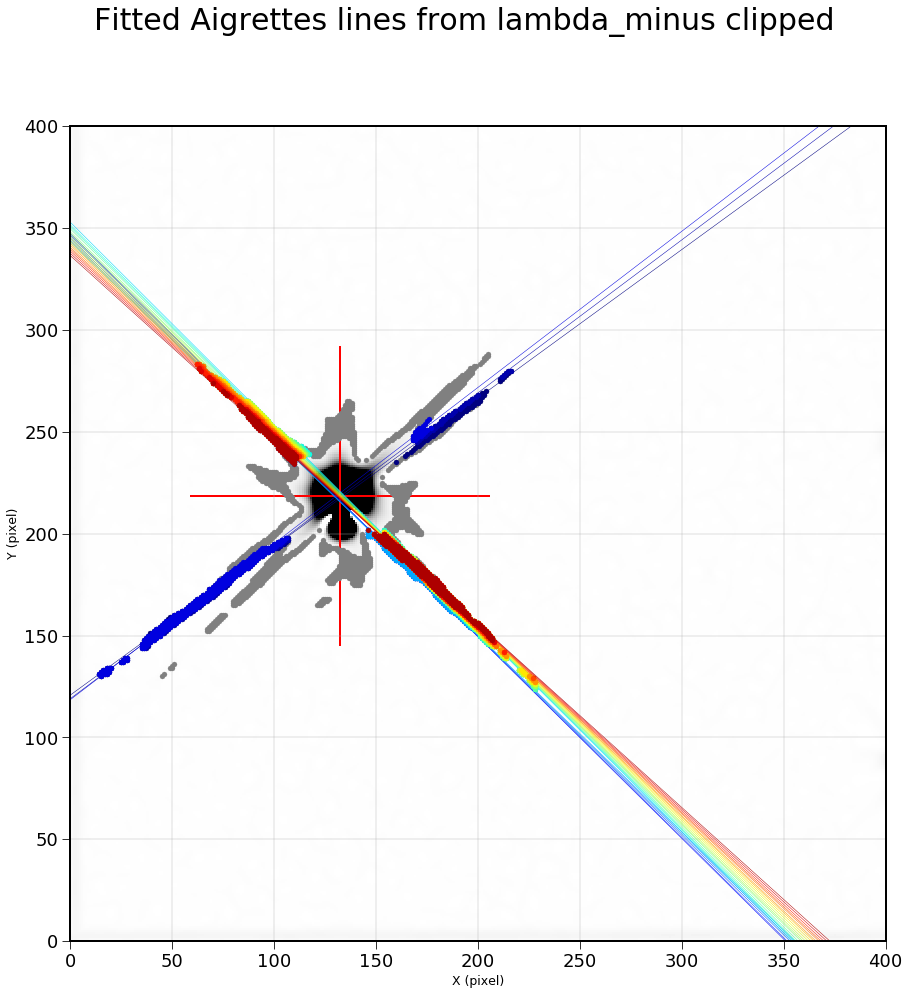

In [247]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

#vmin=original.flatten().min()
#vmax=original.flatten().max()
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
#img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
    
    
plt.scatter([X0],[Y0],marker="+",s=300**2,c="red",lw=2)

plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)
  

Text(0.5, 0.99, 'Fitted Aigrettes lines from lambda_minus clipped')

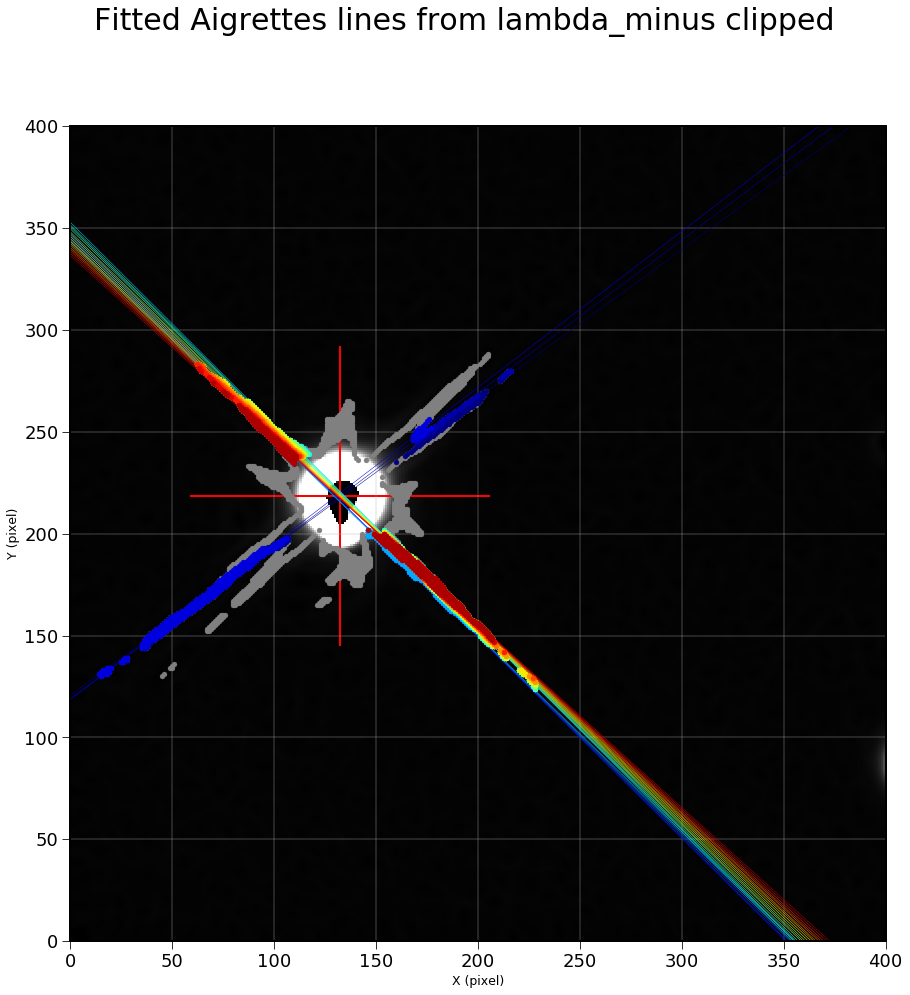

In [248]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

#vmin=original.flatten().min()
#vmax=original.flatten().max()
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
#img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
    
    
plt.scatter([X0],[Y0],marker="+",s=300**2,c="red",lw=2)

plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)
  

Text(0.5, 0.99, 'Fitted Aigrettes lines from lambda_minus clipped')

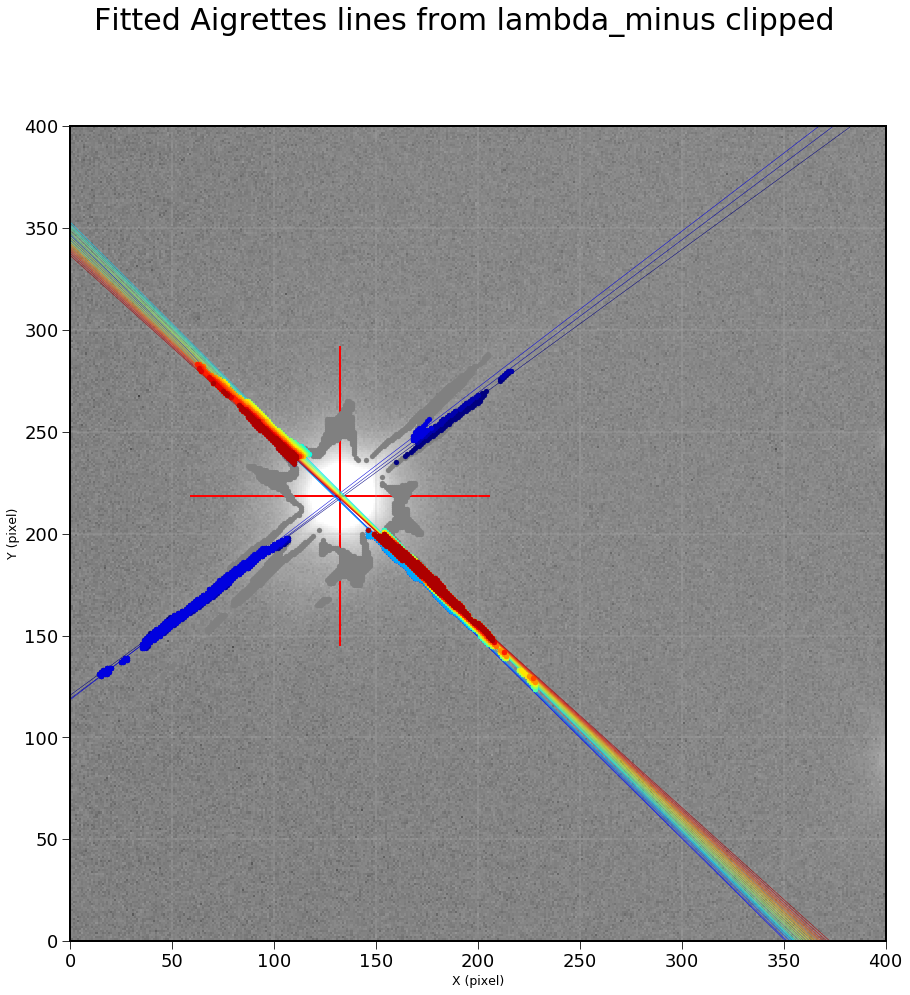

In [249]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

vmin=original.flatten().min()
vmax=original.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
    
    
plt.scatter([X0],[Y0],marker="+",s=300**2,c="red",lw=2)

plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)
  